# Ibis demo

Ibisはpandasの作者[Wes](https://github.com/wesm)が作ったライブラリです。
pandasと大規模データをつなぐ橋渡しをします。

pandasだとメモリに載せた処理が必須でしたが、Ibisは裏側にSQLエンジンを使うことで、大規模データをあたかもDataFrameを扱うようにプログラマブルにpandas likeな処理ができます。

今回のデモでは、IbisとImpalaを組み合わせてデータの傾向を可視化して確認しながら、機械学習のモデルを作ります。

In [1]:
import ibis
import os
ibis.options.interactive = True

In [2]:
# Connection
hdfs_port = os.environ.get('IBIS_WEBHDFS_PORT', 50070)
hdfs_host = os.environ.get('HDFS_HOST','localhost')
hdfs = ibis.hdfs_connect(host=hdfs_host, port=hdfs_port)

impala_port = os.environ.get('IMPALA_PORT', 21050)
impala_host = os.environ.get('IMPALA_HOST','localhost')
con = ibis.impala.connect(host=impala_host, port=impala_port, database='default',
                          hdfs_client=hdfs)

# MovieLens 20Mを対象に、映画の好みを機械学習で予測する

レコメンデーションの実験でよく利用される、[Movie Lens](http://grouplens.org/datasets/movielens/)というデータセットを使って映画の好みを予測するモデルを学習する。

- タグデータ、評価データ、映画データの説明
- 評価データの傾向の確認
- 特定のユーザの好みを予測するモデルを[scikit-learn](http://scikit-learn.org/)で学習する

## データの情報
今回は20Mのデータを利用する。  

> Stable benchmark dataset. 20 million ratings and 465,000 tag applications applied to 27,000 movies by 138,000 users. Released 4/2015.

2千万件の映画の評価データが含まれる。  

予め作ってS3に置いた、parquet形式のテーブルを利用している。

### タグデータ

ユーザID、映画ID、ユーザーが付与した映画のタグ、付与した日時(Unixtime)が含まれる。

In [3]:
tags = con.table('tags_pq_s3')

tags.limit(10).execute()

,userid,movieid,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078
5,65,668,bollywood,1368149876
6,65,898,screwball comedy,1368150160
7,65,1248,noir thriller,1368149983
8,65,1391,mars,1368150055
9,65,1617,neo-noir,1368150217


### 評価データ

ユーザID、映画ID、評価値（0-5で0.5刻み）、付与した日時(Unixtime)が含まれる。

In [4]:
ratings = con.table('ratings_pq_s3')
ratings

      userid  movieid  rating   timestamp
0          1        2     3.5  1112486027
1          1       29     3.5  1112484676
2          1       32     3.5  1112484819
3          1       47     3.5  1112484727
4          1       50     3.5  1112484580
5          1      112     3.5  1094785740
6          1      151     4.0  1094785734
7          1      223     4.0  1112485573
8          1      253     4.0  1112484940
9          1      260     4.0  1112484826
10         1      293     4.0  1112484703
11         1      296     4.0  1112484767
12         1      318     4.0  1112484798
13         1      337     3.5  1094785709
14         1      367     3.5  1112485980
15         1      541     4.0  1112484603
16         1      589     3.5  1112485557
17         1      593     3.5  1112484661
18         1      653     3.0  1094785691
19         1      919     3.5  1094785621
20         1      924     3.5  1094785598
21         1     1009     3.5  1112486013
22         1     1036     4.0  111

### Unixtimeをdatetime型に変換する

元データはUnixtime (int)で格納されているので、年ごとに分析できるようにdatetime型に変換する。

In [5]:
expr = ratings.timestamp.cast('timestamp')
ratings2 = ratings['userid', 'movieid', 'rating', expr.name('datetime') ]
ratings2

      userid  movieid  rating            datetime
0      67288     1358     4.0 2006-11-01 04:33:26
1      67288     1370     4.0 2006-11-01 04:35:55
2      67288     1380     3.5 2006-11-01 04:35:52
3      67288     1387     3.5 2006-06-12 03:22:32
4      67288     1393     2.0 2006-07-02 03:22:53
5      67288     1394     2.0 2006-11-01 04:30:00
6      67288     1407     1.0 2006-11-01 04:27:58
7      67288     1408     4.5 2006-07-02 03:21:40
8      67288     1441     3.5 2006-06-12 03:12:31
9      67288     1446     4.0 2012-08-03 23:27:33
10     67288     1466     4.0 2006-11-01 04:45:29
11     67288     1485     4.0 2006-11-01 04:27:49
12     67288     1513     4.0 2006-11-01 04:49:19
13     67288     1552     4.0 2006-11-01 04:33:16
14     67288     1584     4.0 2006-07-01 22:28:15
15     67288     1608     4.0 2006-11-01 04:29:00
16     67288     1610     4.0 2006-07-02 03:17:46
17     67288     1641     3.5 2006-11-01 04:25:45
18     67288     1645     4.5 2007-06-22 03:18:13


### 映画データ
映画ID、映画名、ジャンル（`|`区切り）が含まれる

In [6]:
movies = con.table('movies_pq_s3')
movies.columns

['movieid', 'title', 'genres']

In [7]:
movies.execute()

,movieid,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


### 評価データの日付をdatetime型に変えてjoinする

クエリは複雑だけど、Impalaの実行計画は上とかわらない

In [8]:
expr = ratings.timestamp.cast('timestamp')
ratings2 = ratings['userid', 'movieid', 'rating', expr.name('datetime') ]
joined2 = ratings2.join(movies, ['movieid'])[ratings2, movies['title']]
print(ibis.impala.compile(joined2))
#print(ibis.impala.compile(joined2.count()))
joined2.materialize().limit(1000).execute()

SELECT t0.*, t1.`title`
FROM (
  SELECT `userid`, `movieid`, `rating`,
         CAST(`timestamp` AS timestamp) AS `datetime`
  FROM default.`ratings_pq_s3`
) t0
  INNER JOIN default.`movies_pq_s3` t1
    ON t0.`movieid` = t1.`movieid`


,userid,movieid,rating,datetime,title
0,1,2,3.5,2005-04-02 23:53:47,Jumanji (1995)
1,1,29,3.5,2005-04-02 23:31:16,"City of Lost Children, The (Cité des enfants p..."
2,1,32,3.5,2005-04-02 23:33:39,Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
3,1,47,3.5,2005-04-02 23:32:07,Seven (a.k.a. Se7en) (1995)
4,1,50,3.5,2005-04-02 23:29:40,"Usual Suspects, The (1995)"
5,1,112,3.5,2004-09-10 03:09:00,Rumble in the Bronx (Hont faan kui) (1995)
6,1,151,4.0,2004-09-10 03:08:54,Rob Roy (1995)
7,1,223,4.0,2005-04-02 23:46:13,Clerks (1994)
8,1,253,4.0,2005-04-02 23:35:40,Interview with the Vampire: The Vampire Chroni...
9,1,260,4.0,2005-04-02 23:33:46,Star Wars: Episode IV - A New Hope (1977)


### レビュー数が多い top 20 ユーザを抽出する

In [9]:
joined2.group_by(joined2.userid). \
aggregate(count=joined2.count()).sort_by(('count', False)).limit(20)

    userid  count
0   118205   9254
1     8405   7515
2    82418   5646
3   121535   5520
4   125794   5491
5    74142   5447
6    34576   5356
7   131904   5330
8    83090   5169
9    59477   4988
10  130767   4785
11   79159   4707
12    8963   4524
13   15617   4354
14   92011   4236
15   71975   4182
16   20132   4101
17   46470   4094
18   88820   4093
19   63147   3958

### レビューが一番多いユーザの年ごとの評価件数を調べる

ただし、2001年の評価が圧倒的に多いので除外する。  

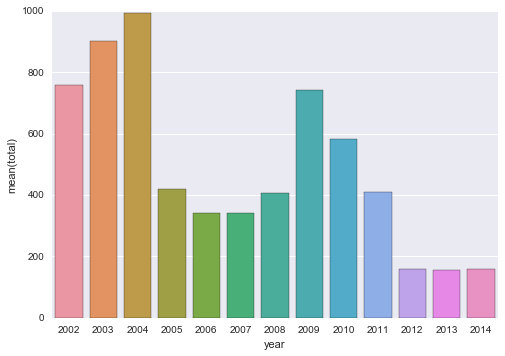

In [10]:
%matplotlib inline
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

# joined3 = joined2.filter([joined2.userid == 118205])
joined3 = joined2.filter([joined2.userid == 118205, joined2.datetime.year() > 2001])

#print(ibis.impala.compile(joined3))
top_user_year_counts = joined3.group_by(joined3.datetime.year()).aggregate(total=joined3.count())

#print('-----------------------------\n\n-----------------------------')
#print(ibis.impala.compile(top_user_year_counts))

sns.barplot(x='year', y='total', data=top_user_year_counts.execute())

### topユーザの評価の傾向から映画と評価点の分割点を調べる

今回は過去の評価データから未来の評価データを予測する。  
そのために、バランスよくpositive/negativeデータに分かれる点数を調べる。  
何点以上を好みとするかを決める。

In [11]:
top_user_ratings = ratings.filter([ratings.userid == 118205])[ratings.movieid, ratings.rating, ratings.timestamp.cast('timestamp').year()]
top_user_ratings

      movieid  rating  year
0           1     4.0  2001
1           2     4.0  2001
2           3     3.0  2001
3           4     3.0  2001
4           5     3.0  2001
5           6     4.0  2001
6           7     3.0  2001
7           8     4.0  2001
8           9     3.0  2001
9          10     4.0  2001
10         11     3.0  2001
11         13     3.0  2009
12         14     4.0  2001
13         16     4.0  2001
14         17     4.0  2001
15         18     3.0  2001
16         19     3.0  2001
17         20     3.0  2001
18         21     4.0  2001
19         22     3.0  2001
20         23     3.0  2001
21         24     3.0  2003
22         25     4.0  2001
23         26     4.0  2001
24         27     3.0  2002
25         28     4.0  2001
26         29     4.0  2001
27         30     4.0  2001
28         31     3.0  2001
29         32     4.0  2001
...       ...     ...   ...
9224   114146     3.0  2014
9225   114217     3.0  2014
9226   114398     3.0  2014
9227   114400     3.

点数データの分布から、今回は3.5点以上を好みとする。  
なお、2008年以前のデータで学習、2009年以降のデータで評価をする。

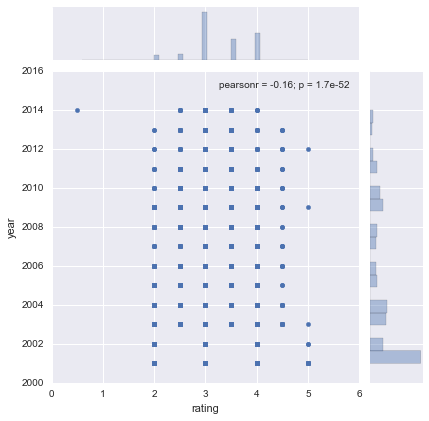

In [12]:
top_user_rating_df = top_user_ratings[top_user_ratings.rating, top_user_ratings.year].execute()
sns.jointplot(x='rating', y='year', data=top_user_rating_df)

### 特徴量を抽出する

通常、レコメンデーションでは協調フィルタリングをすることが多いが、今回は1人のユーザのモデルベースの推薦をするので、映画に付与されたタグのテキスト情報をもとに特徴量を抽出する。  
つまり、テキスト分類の問題として考える。  

まず、各ユーザが付与したタグ情報を、映画ID毎に集約する

In [13]:
movie_tags = tags.group_by(tags.movieid).aggregate(tag=tags.tag.group_concat(', ').lower()).limit(100000)
movie_tags.execute()

,movieid,tag
0,4,"chick flick, revenge, characters, chick flick,..."
1,37335,"wuxia, 03/10, 06/10, 11/10, kick-butt women, k..."
2,32582,"a deadhead with a parrot fetish, parrots, beau..."
3,69689,"island, not available from netflix, not on dvd..."
4,4113,"author:tennessee williams, john malkovich, pau..."
5,83837,"buster keaton, edward f. cline"
6,5045,"exploitation, sexploitation, imdb bottom 100, ..."
7,103003,"amputation, amputee, b.i.d.d., body dysphoria,..."
8,75818,"best of rotten tomatoes: all time, havana mark..."
9,928,"adapted from:book, adultery, animal:dog, autho..."


In [14]:
# データの偏りを考慮して、3.5以上をpositive, 未満をnegativeとする
old_pos_tags = movie_tags[movie_tags.movieid.isin(top_user_ratings.filter([top_user_ratings.rating >= 3.5, top_user_ratings.year.between(2002, 2008)]).movieid)].tag.execute()
old_neg_tags = movie_tags[movie_tags.movieid.isin(top_user_ratings.filter([top_user_ratings.rating < 3.5, top_user_ratings.year.between(2002, 2008)]).movieid)].tag.execute()
new_pos_tags = movie_tags[movie_tags.movieid.isin(top_user_ratings.filter([top_user_ratings.rating >= 3.5, top_user_ratings.year > 2008]).movieid)].tag.execute()
new_neg_tags = movie_tags[movie_tags.movieid.isin(top_user_ratings.filter([top_user_ratings.rating < 3.5, top_user_ratings.year > 2008]).movieid)].tag.execute()

In [15]:
# 好きな映画を`1`、嫌いな映画を`-1`として、正解ラベルデータを作る
import pandas as pd

old_tag_labels = [1] * len(old_pos_tags) + [-1] * len(old_neg_tags)
new_tag_labels = [1] * len(new_pos_tags) + [-1] * len(new_neg_tags)

old_tags = pd.concat([old_pos_tags, old_neg_tags], ignore_index=True)
new_tags = pd.concat([new_pos_tags, new_neg_tags], ignore_index=True)

### scikit-learnでロジスティック回帰を使って学習する

`CountVectorizer`を使うことで、テキストの頻度ベースのベクトルを作れる。  
今回は、Bag of Wordsで特徴ベクトルを作成する。

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ('vect', CountVectorizer(binary=True)),
        ('clf', LogisticRegression(random_state=42))
    ])
clf.fit(old_tags, old_tag_labels)

Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=True, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_...alty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [17]:
# 新しい映画の1つ目（positive = 1）を予測
clf.predict([new_tags.iloc[1]])

array([1])

In [18]:
# 新しい映画の最後（negative = -1）を予測
clf.predict([new_tags.iloc[-1]])

array([-1])

In [19]:
from sklearn.metrics import classification_report, f1_score

new_pred_labels = clf.predict(new_tags)
print(classification_report(new_tag_labels, new_pred_labels))
f1_score(new_tag_labels, new_pred_labels)

             precision    recall  f1-score   support

         -1       0.67      0.84      0.74       951
          1       0.71      0.47      0.57       763

avg / total       0.68      0.68      0.67      1714



0.5664830841856805

### scikit-learnで線形SVMを使って学習する

アルゴリズムをSVMを使って学習する。その際に、`GridSearchCV`を使ってパラメータ探索をする。

In [20]:
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

pl2 = Pipeline([
        ('vect', CountVectorizer(binary=True)),
        ('clf', SVC(kernel='linear', random_state=42))
    ])
param_grid = dict(clf__C=[0.01, 0.1, 1, 10])

clf = GridSearchCV(pl2, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)
clf.fit(old_tags, old_tag_labels)

print("\n+ Best parameters:\n")
print(clf.best_estimator_)

print("\n+ Average score with CV of traning data set:\n")
for params, mean_score, all_scores in clf.grid_scores_:
    print("{:.3f} (+/- {:.3f}) for {}".format(mean_score, all_scores.std() / 2, params))

print("\n+ Predict report of test data set:\n")
y_true, y_pred = new_tag_labels, clf.predict(new_tags)
print(classification_report(y_true, y_pred))


+ Best parameters:

Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=True, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_...r',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False))])

+ Average score with CV of traning data set:

0.616 (+/- 0.027) for {'clf__C': 0.01}
0.668 (+/- 0.021) for {'clf__C': 0.1}
0.654 (+/- 0.012) for {'clf__C': 1}
0.629 (+/- 0.016) for {'clf__C': 10}

+ Predict report of test data set:

             precision    recall  f1-score   support

         -1       0.65      0.89      0.75       951
          1       0.75      0.41      0.53       763

avg / total       0.70      0.68      0.65      1714



### Furture works

[spark-sklearn](https://github.com/databricks/spark-sklearn)を使うことで、`GridSearchCV`を使ったパラメータ探索をsparkで分散して行える。  
なおspark-sklearnには、`LogisticRegression`と`LinearRegression`はSparkのRDDに変換するメソッドがある。